In [1]:
# Copyright 2018 Steven Sheffey
# This file is part of packet_captor_sakura.
#
# packet_captor_sakura is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# packet_captor_sakura is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with packet_captor_sakura.  If not, see <https:# www.gnu.org/licenses/>.
import datetime
import gzip
from itertools import permutations
import logging
import json
from pathlib import Path
import random
import time
import typing

from IPython.display import display, Math, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors.kde import KernelDensity
from sklearn import utils as sklearn_utils
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm, tnrange

# Set up the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Set up matplotlib magic
%matplotlib inline

# Load and prepare dataset

In [2]:


def load_data(data_root):
    def load_data(filename: str):
        return pd.read_json(filename, lines=True) \
            .rename(index=str, columns={
                "c": "class",
                "u": "url",
                "f": "is_first_of_type",
                "pl": "packet_length_bins",
                "iaf": "interarrival_time_from_client_bins",
                "iat": "interarrival_time_to_client_bins"
            })
    def filter_firsts(df):
        return df.loc[df["is_first_of_type"] == False]

    def reorder_columns(df):
        return df[["packet_length_bins", "interarrival_time_from_client_bins", "interarrival_time_to_client_bins"]]

    def to_numpy(df):
        return np.array(df.values.tolist(), dtype=np.float32)


    # Load datasets
    normal_data = load_data(data_root / "normal.json.gz")
    tor_data = load_data(data_root / "tor.json.gz")

    # Print initial dataset size
    print(f"Normal entries: {len(normal_data.index)}")
    print(f"Tor entries: {len(tor_data.index)}")
    
    filter_first = False
    if filter_first:
        normal_data = filter_firsts(normal_data)
        tor_data = filter_firsts(tor_data)
        print("Normal entries after filter: {}".format(normal_data.count()))
        print("Tor entries after filter: {}".format(tor_data.count()))
    
    normal_data = reorder_columns(normal_data)
    tor_data = reorder_columns(tor_data)
    
    normal_data = to_numpy(normal_data)
    tor_data = to_numpy(tor_data)
    print(f"Normal data shape: {normal_data.shape}")
    print(f"Tor data shape: {tor_data.shape}")

    # Equalize samples
    min_samples = min(tor_data.shape[0], normal_data.shape[0])
    normal_data = normal_data[:min_samples]
    tor_data = tor_data[:min_samples]

    # Print dimensions
    print(f"Normal data shape after classes balanced: {normal_data.shape}")
    print(f"Tor data shape after classes balanced: {tor_data.shape}")
    return normal_data, tor_data

# Generate figures for initial features

In [3]:
FIGURE_DIR = Path('figures')

def generate_figures(normal_data, tor_data, figure_dir, figure_size):
    sns.set()
    sns.set_style('whitegrid')
    plt.rcParams.update({'savefig.dpi': 1200})
    ps_bins = list(map(str, list(range(0,100+1, 10)) + list(range(200,1000+1,100)) + list(range(2000,10000+1,1000)) + ['∞']))
    ia_bins = list(map(str, list(range(0,10+1)) + list(range(20,100+1,10)) + list(range(200,1000+1,100)) + ['∞']))

    # Average fields for each dataset and feature
    data = {
        "x": [i + 0.5 for i in range(29)],
        "tor_ps":     tor_data[:,0,:].mean(axis=0),
        "normal_ps":  normal_data[:,0,:].mean(axis=0),
        "tor_iaf":    tor_data[:,1,:].mean(axis=0),
        "normal_iaf": normal_data[:,1,:].mean(axis=0),
        "tor_iat":    tor_data[:,2,:].mean(axis=0),
        "normal_iat": normal_data[:,2,:].mean(axis=0),
    }
    # Start plotting packet sizes
    fig = plt.figure(figsize=figure_size)
    sns.lineplot("x", "tor_ps", label="Meek", data=data)
    ax = sns.lineplot("x", "normal_ps", label="HTTPS", data=data)
    ax.legend()
    plt.setp(ax.get_legend().get_texts(), fontsize='26') # for legend text
    ax.set_xlabel("TCP Payload length (bytes)", fontsize=28)
    ax.set_ylabel("Frequency", fontsize=28)
    ax.set_xticks(range(30))
    ax.set_xticklabels(ps_bins, rotation=90)
    ax.tick_params(labelsize=22)
    fig.savefig(figure_dir / 'initial-features-packet-size.pdf', bbox_inches='tight')
    plt.show()
    # Start plotting interarrival from client
    fig = plt.figure(figsize=figure_size)
    sns.lineplot("x", "tor_iaf", label="Meek", data=data)
    ax = sns.lineplot("x", "normal_iaf", label="HTTPS", data=data)
    ax.legend()
    plt.setp(ax.get_legend().get_texts(), fontsize='26') # for legend text
    ax.set_xlabel("Inter-arrival time from client (ms)", fontsize=28)
    ax.set_ylabel("Frequency", fontsize=28)
    ax.set_xticks(range(30))
    ax.set_xticklabels(ia_bins, rotation=90)
    ax.tick_params(labelsize=22)
    fig.savefig(figure_dir / 'initial-features-iaf.pdf', bbox_inches='tight')
    plt.show()
    # Start plotting interarrival to client
    fig = plt.figure(figsize=figure_size)
    sns.lineplot("x", "tor_iat", label="Meek", data=data)
    ax = sns.lineplot("x", "normal_iat", label="HTTPS", data=data)
    ax.legend()
    plt.setp(ax.get_legend().get_texts(), fontsize='26') # for legend text
    ax.set_xlabel("Inter-arrival time to client (ms)", fontsize=28)
    ax.set_ylabel("Frequency", fontsize=28)
    ax.set_xticks(range(30))
    ax.set_xticklabels(ia_bins, rotation=90)
    ax.tick_params(labelsize=22)
    fig.savefig(figure_dir / 'initial-features-iat.pdf', bbox_inches='tight')
    plt.show()


# GAN

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes, **config):
        super(Discriminator, self).__init__()
        # Get hidden layer_size
        hidden_layer_size = config.get("hidden_layer_size", 64)
        # Hidden layer
        self.fc1 = nn.Linear(np.product(input_dim), hidden_layer_size)
        # Output fake/real
        self.src_out = nn.Linear(hidden_layer_size, 1)
        # Output class
        self.class_out = nn.Linear(hidden_layer_size, num_classes)

    def forward(self, x):
        x = x.flatten(-2)
        x = F.leaky_relu(self.fc1(x))
        # x = F.leaky_relu(self.fc2(x))
        return self.src_out(x), self.class_out(x)

class Generator(nn.Module):
    def __init__(self, input_dim, num_classes, **config):
        super(Generator, self).__init__()
        # Store input dimensions
        self.input_dim = input_dim
        # Get hidden layer_size
        hidden_layer_size = config.get("hidden_layer_size", 128)
        # Hidden layer
        self.fc1 = nn.Linear(np.product(input_dim) + 1, hidden_layer_size)
        # Output layer
        self.out = nn.Linear(hidden_layer_size, np.product(input_dim))
        

    def forward(self, input_data, target_class):
        x = torch.cat((input_data.flatten(-2), target_class.view(target_class.shape[0], 1).float()), 1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x.view(-1, *self.input_dim)

def train_gan(x, y, **config):
    """
    Trains a StarGAN to build a discriminator that classifies traffic,
    and a generator that modifies traffic to trick the discriminator
    """
    if config is None:
        config = {}
    # Training device
    device = torch.device(config.get('device', 'cpu'))
    # Find the input dimensions
    input_dim = x.shape[-2:]
    # Number of classes
    num_classes = 2
    # Hyperparameters
    # Minibatch size
    batch_size = config.get("batch_size", 16)
    # Default number of iterations is 1 epoch
    num_iters = config.get("num_iters", input_dim[0] // batch_size)
    # Generator learning rate
    g_lr = config.get("g_lr", 0.0001)
    # Discriminator learning rate
    d_lr = config.get("d_lr", 0.0001)
    # Betas for optimizer
    beta1 = config.get("beta1", 0.5)
    beta2 = config.get("beta2", 0.999)
    # Loss weights
    lambda_gp = config.get("lambda_gp", 10)
    lambda_cls = config.get("lambda_cls", 1)
    lambda_rec = config.get("lambda_rec", 10)
    lambda_del = config.get("lambda_del", 10)
    # Number of iterations to train discriminator before training generator
    n_critic = config.get("n_critic", 5)
    # Number of iterations to wait before logging loss
    log_step = config.get("log_step", 100)
    # Expected amount of improvement before quitting
    improvement_amount = config.get("improvement_amount", 1e-2)
    # Number of iterations to wait to check for improvement
    improvement_patience = config.get("improvement_patience", 1000)

    # Initialize models
    discriminator = Discriminator(input_dim, num_classes).to(device)
    generator = Generator(input_dim, num_classes).to(device)
    
    # Initialize optimizers
    g_optimizer = torch.optim.Adam(generator.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(discriminator.parameters(), d_lr, [beta1, beta2])
    
    # Convert the training set to tensors
    x_tensor = torch.from_numpy(x).to(device)
    y_tensor = torch.from_numpy(y).to(device)
    
    # Create a dataset from the training tensors
    dataset = TensorDataset(x_tensor, y_tensor)
    # Abstract tensor data loading
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    data_iter = iter(data_loader)

    # Define our classification loss function
    def classification_loss(logit, target):
        return F.cross_entropy(logit, target)
    
    # Define our gradient penalty
    def gradient_penalty(y, x):
        """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
        weight = torch.ones(y.size()).to(device)
        dydx = torch.autograd.grad(outputs=y,
                                   inputs=x,
                                   grad_outputs=weight,
                                   retain_graph=True,
                                   create_graph=True,
                                   only_inputs=True)[0]
        dydx = dydx.view(dydx.size(0), -1)
        dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
        return torch.mean((dydx_l2norm-1)**2)
    
    # Resets the gradients on our optimizers
    def reset_grad():
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()
    
    # Record the time before training starts
    start_time = time.time()
    
    # Keep track of best losses
    best_d_loss = 1e20
    best_d_loss_e = 0
    best_g_loss = 1e20
    best_g_loss_e = 0
    
    # Make a progress bar
    bar = tqdm(desc="GAN Iteration", total=num_iters + 1, position=2)
    
    # Iterate over the dataset
    for i in range(1, num_iters + 1):
        # Move the progress bar forward
        bar.update(1)
        # =================================================================================== #
        #                             1. Preprocess input data                                #
        # =================================================================================== #
        # Take a batch from the dataset iterator
        try:
            x_real, label_org = next(data_iter)
        # Restart iteration over the dataset iterator when it runs out of batches
        except StopIteration:
            data_iter = iter(data_loader)
            x_real, label_org = next(data_iter)
        
        # Generate target domain labels randomly.
        rand_idx = torch.randperm(label_org.size(0))
        label_trg = label_org[rand_idx]
        
        # Send data to compute device
        x_real = x_real.to(device)              # Input images.
        c_org = label_org.to(device, copy=True) # Original domain labels.
        c_trg = label_trg.to(device, copy=True) # Target domain labels.
        label_org = label_org.to(device)        # Labels for computing classification loss.
        label_trg = label_trg.to(device)        # Labels for computing classification loss.

        # =================================================================================== #
        #                             2. Train the discriminator                              #
        # =================================================================================== #
        # Compute loss with real images.
        out_src, out_cls = discriminator(x_real)
        d_loss_real = - torch.mean(out_src)
        d_loss_cls = classification_loss(out_cls, label_org)

        # Compute loss with fake images.
        x_fake = generator(x_real, c_trg)
        out_src, out_cls = discriminator(x_fake.detach())
        d_loss_fake = torch.mean(out_src)

        # Compute loss for gradient penalty.
        alpha = torch.rand(x_real.size(0), 1, 1, 1).to(device)
        x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
        out_src, _ = discriminator(x_hat)
        d_loss_gp = gradient_penalty(out_src, x_hat)

        # Backward and optimize.
        d_loss = d_loss_real + d_loss_fake + \
                 lambda_cls * d_loss_cls + \
                 lambda_gp * d_loss_gp
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # Store loss values
        loss = {}
        loss['D/loss_real'] = d_loss_real.item()
        loss['D/loss_fake'] = d_loss_fake.item()
        loss['D/loss_cls'] = d_loss_cls.item()
        loss['D/loss_gp'] = d_loss_gp.item()
        loss['D/loss'] = d_loss.item()
        
        # =================================================================================== #
        #                               3. Train the generator                                #
        # =================================================================================== #
        # If this is a generator iteration, train the generator on the current mini batch
        if (i+1) % n_critic == 0:
            # Original-to-target domain.
            x_fake = generator(x_real, c_trg)
            out_src, out_cls = discriminator(x_fake)
            g_loss_fake = - torch.mean(out_src)
            g_loss_cls = classification_loss(out_cls, label_trg)
            
            # Measure original-to-target domain perturbation
            g_loss_del = torch.mean(torch.abs(x_fake - x_real))
            
            # Target-to-original domain.
            x_reconst = generator(x_fake, c_org)
            g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))
            
            # Backward and optimize.
            g_loss = g_loss_fake + lambda_rec * g_loss_rec + lambda_cls * g_loss_cls + lambda_del * g_loss_del
            reset_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # Logging.
            loss['G/loss_fake'] = g_loss_fake.item()
            loss['G/loss_rec'] = g_loss_rec.item()
            loss['G/loss_cls'] = g_loss_cls.item()
            loss['G/loss_del'] = g_loss_del.item()
            loss['G/loss'] = g_loss.item()

            # EARLY STOPPING
            # Only perform on generator iterations
            # If changes are enough to warrant an update of the best
            if best_d_loss - d_loss.item() >= improvement_amount or best_g_loss - g_loss.item() >= improvement_amount:
                if best_d_loss - d_loss.item() >= improvement_amount:
                    best_d_loss = d_loss.item()
                    best_d_loss_e = i
                if best_g_loss - g_loss.item() >= improvement_amount:
                    best_g_loss = g_loss.item()
                    best_g_loss_e = i
            # If neither discriminator nor generator loss have improved by some number of epochs
            elif (i-best_d_loss_e) > improvement_patience and \
               (i-best_g_loss_e) > improvement_patience:
                et = time.time() - start_time
                et = str(datetime.timedelta(seconds=et))[:-7]
                loss["status"] = "Exiting early to avoid overfitting"
                bar.set_postfix(loss)
                bar.close()
                break
            if (i+1) % log_step == 0:
                bar.set_postfix(loss)
        # =================================================================================== #
        #                                 4. Miscellaneous                                    #
        # =================================================================================== #
    bar.close()
    # Return the trained discriminator and generator
    return (discriminator, generator)
def evaluate_discriminator(discriminator, x_tensor, y_true, prefix=None):
    """
    Evaluates the discriminator
    :param x: Tensor input
    :param y: Numpy output
    """
    if prefix is None:
        prefix = ""
    else:
        prefix = f"{prefix}/"
    # Feed the input through the classifier
    _, y_predicted_tensor = discriminator(x_tensor)
    y_predicted = np.argmax(y_predicted_tensor.detach().numpy(), axis=1)
    # Calculate PR-AUC of the classifier's predictions
    pr_auc = average_precision_score(y_true, y_predicted)
    # Calculate a confusion matrix
    confusion_m = confusion_matrix(y_true, y_predicted)
    # Calculate FPR
    tn, fp, _, _ = confusion_m.ravel()
    fpr = float(fp) / float(fp + tn)
    # Accuracy of the classifier's predictions
    accuracy = accuracy_score(y_true, y_predicted)
    # Collect all metrics into an object
    metrics = {"pr_auc": pr_auc, "confusion_matrix": confusion_m, "accuracy": accuracy, "fpr": fpr}
    # Return metrics
    return {f"{prefix}{key}": value for key, value in metrics.items()}

# Neural Net 

In [5]:
class Classifier(nn.Module):
    def __init__(self, input_dim, **config):
        super(Classifier, self).__init__()
        # Get hidden layer size
        hidden_layer_size = config.get("hidden_layer_size", 16)
        # Hidden layer
        self.fc1 = nn.Linear(np.product(input_dim), hidden_layer_size)
        # Output layer
        self.out = nn.Linear(hidden_layer_size, 1)
    def forward(self, x):
        x = x.flatten(-2)
        # x = F.relu(self.fc1(x))
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.out(x))

def train_classifier(x, y, **config):
    """
    Trains a basic traffic classifier
    """
    if config is None:
        config = {}
    # Training device
    device = torch.device(config.get("device", "cpu"))
    
    # Validation size
    validation_size = config.get("validation_size", 0.1)
    
    # Hyperparameters
    batch_size = config.get("batch_size", 16)
    lr = config.get("lr", 1e-4)
    beta1 = config.get("beta1", 0.5)
    beta2 = config.get("beta2", 0.999)
    log_step = config.get("log_step", 10)
    num_epochs = config.get("num_epochs", 100)
    # Early stopping parameters
    improvement_patience = config.get("improvement_patience", 5)
    improvement_amount = config.get("improvement_amount", 1e-3)

    # Find the input dimensions
    input_dim = x.shape[-2:]

    # Initialize the model
    classifier = Classifier(input_dim).to(device)
    # Initialize the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(), lr, betas=(beta1, beta2))
    # Initialize the loss
    criterion = nn.BCELoss()
    
    # Split the dataset
    x, x_v, y, y_v = train_test_split(x, y, test_size=validation_size, train_size=None)
    
    # Convert the training set from numpy to torch
    x = torch.from_numpy(x)
    y = torch.from_numpy(y).float()
    # Convert the validation set from numpy to torch
    x_v = torch.from_numpy(x_v)
    y_v = torch.from_numpy(y_v).float().view(-1,1)
    # Create a dataset from the test training set
    dataset = TensorDataset(x, y.view(-1,1))
    # Abstract tensor data loading
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    # Keep track of previous validation losses
    best_val_loss = 1e20
    best_val_loss_e = 0
    # Make a progress bar
    bar = tqdm(desc="Classifier epoch", total=num_epochs, position=3)
    # Iterate for some number of epochs
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        for batch in data_loader:
            # Separate data in the batch
            inputs, labels = batch
            # Send data to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Accumulate loss
            epoch_loss += loss.item()
        # Calculate validation loss
        outputs_v = classifier(x_v)
        loss_v = criterion(outputs_v, y_v).item()
        # Log if on a log epoch
        if epoch % log_step == 0:
            loss = {'loss': epoch_loss / x.shape[0], 'val_loss': loss_v / x_v.shape[0]}
            bar.set_postfix(loss)
        # If validation loss improvement is enough to be considered an upgrade, log it
        if best_val_loss - loss_v >= improvement_amount:
            #print(f'{epoch}: class loss update {best_val_loss} to {loss_v}')
            best_val_loss = loss_v
            best_val_loss_e = epoch
        # If it has been some number of epochs since the last loss improvement, quit
        elif (epoch - best_val_loss_e) > improvement_patience:
            loss = {'loss': epoch_loss / x.shape[0], 'val_loss': loss_v / x_v.shape[0], 'status': "Exiting early to avoid overfitting"}
            bar.set_postfix(loss)
            bar.close()
            # Because we are in a nested loop, we must return
            return classifier
        # Reset epoch loss
        epoch_loss = 0.0
        # Update bar
        bar.update()
    bar.close()
    return classifier
def evaluate_classifier(classifier, x_tensor, y_true, prefix=None):
    """
    Evaluates a classifier on a dataset
    :param x: Tensor input
    :param y: Numpy output
    """
    # Set the prefix
    if prefix is None:
        prefix = ""
    else:
        prefix = f"{prefix}/"
    # Feed the input through the classifier
    y_predicted_tensor = classifier(x_tensor)
    y_predicted = y_predicted_tensor.detach().numpy()
    # Calculate PR-AUC of the classifier's predictions
    pr_auc = average_precision_score(y_true, y_predicted)
    # Create a version of the predictions that is absolute
    # by rounding to the nearest integer
    y_predicted_abs = np.rint(y_predicted)
    # Calculate a confusion matrix
    confusion_m = confusion_matrix(y_true, y_predicted_abs)
    # Calculate FPR
    tn, fp, _, _ = confusion_m.ravel()
    fpr = float(fp) / float(fp + tn)
    # Accuracy of the classifier's predictions
    accuracy = accuracy_score(y_true, y_predicted_abs)
    # Collect all metrics into an object
    metrics = {"pr_auc": pr_auc, "confusion_matrix": confusion_m, "accuracy": accuracy, "fpr": fpr}
    # Return metrics
    return {f"{prefix}{key}": value for key, value in metrics.items()}

# Decision Tree

In [6]:
def train_dt(x, y, **config):
    # Extract random state from config
    random_state = config.get("random_state", None)
    # Build a decision tree
    dt = DecisionTreeClassifier(random_state=random_state)
    # Flatten the input
    x_flat = x.reshape(x.shape[0], np.product(x.shape[1:]))
    # Train the decision tree on the given data
    dt.fit(x_flat, y)
    # Return the model
    return dt

def evaluate_dt(dt, x, y_true, prefix=None):
    """
    Evaluates a classifier on a dataset
    :param x: Tensor input
    :param y: Numpy output
    """
    # Set the prefix
    if prefix is None:
        prefix = ""
    else:
        prefix = f"{prefix}/"
    # Feed the input through the classifier
    y_predicted = dt.predict(x.reshape(x.shape[0], np.product(x.shape[1:])))
    # Calculate PR-AUC of the classifier's predictions
    pr_auc = average_precision_score(y_true, y_predicted)
    # Calculate a confusion matrix
    confusion_m = confusion_matrix(y_true, y_predicted)
    # Calculate FPR
    tn, fp, _, _ = confusion_m.ravel()
    fpr = float(fp) / float(fp + tn)
    # Accuracy of the classifier's predictions
    accuracy = accuracy_score(y_true, y_predicted)
    # Collect all metrics into an object
    metrics = {"pr_auc": pr_auc, "confusion_matrix": confusion_m, "accuracy": accuracy, "fpr": fpr}
    # Return metrics
    return {f"{prefix}{key}": value for key, value in metrics.items()}

# Combine datasets

In [7]:
NUM_CLASSES=2
def combine_datasets(normal_data, tor_data):
    # Create labels for the normal and tor datasets
    y_normal = np.repeat(0, normal_data.shape[0])
    y_tor = np.repeat(1, tor_data.shape[0])
    # Concatenate the normal and tor datasets into one large dataset
    x = np.concatenate((normal_data, tor_data))
    y = np.concatenate((y_normal, y_tor))
    # Print some info about the dataset
    display(Markdown(f"**Dataset input shape**: {x.shape}"))
    display(Markdown(f"**Dataset output shape**: {y.shape}"))
    return x,y

# Helper functions

In [8]:
def print_confusion_matrix(cm, labels):
    for truth, row in enumerate(cm):
        for pred, freq in enumerate(row):
            print("Predicted {} but got {}: {}".format(labels[truth],labels[pred],freq))

def split_proportionally(datasets, proportions, shuffle=True, random_state=None):
    """
    Splits datasets into given proportions and yields each permutation of
    these splits
    :param datasets list(np.array): Datasets to split
    :param proportions list(float): Proportions to use for splitting
    :param shuffle: Whether to shuffle the datasets before splitting
    :param random_state: Used to seed the shuffle
    :yields permutations of the given dataset splits:
    """
    # Ensure there is at least one dataset
    if len(datasets) == 0:
        raise Exception("Must provide at least one dataset")
    # Ensure all datasets have the same first dimension
    dataset_len = datasets[0].shape[0]
    for dataset in datasets[1:]:
        if dataset.shape[0] != dataset_len:
            raise Exception("All datasets must be of equal length")
    # Ensure there is at least 2 proportins
    if len(proportions) < 2:
        raise Exception("Not enough proportion values")
    # Shuffle once, initially if told to
    if shuffle:
        datasets = sklearn_utils.shuffle(*datasets, random_state=random_state)
    # Start iterating over permutations
    for permutation in permutations(range(len(proportions))):
        # Create proportions from the permutation
        cur_proportions = [proportions[i] for i in permutation]
        # Start with the full dataset
        dataset_remainders = datasets
        # Accumulate split datasets
        # dataset_0_split_0, dataset_1_split_0, dataset_1_split_0, dataset_1_split_1, ...
        split_datasets = []
        # Iterate with proportions until the end
        for idx, proportion in enumerate(cur_proportions[:-1]):
            # Determine the current proportions fraction of the remaining dataset
            cur_fraction = float(proportion) / (proportion + sum(cur_proportions[idx + 1:]))
            # After each split, we get a new set of remainders
            new_remainders = []
            # Split each dataset
            for dataset in dataset_remainders:
                # Perform the split using sklearn
                split_dataset, remainder_dataset = train_test_split(dataset, train_size=cur_fraction, test_size=None, shuffle=False)
                # Split dataset goes onto the list
                split_datasets.append(split_dataset)
                # Remainder dataset goes into the remainders
                new_remainders.append(remainder_dataset)
            # Replace remainders
            dataset_remainders = new_remainders
        # Add the remaining remainders to the split list
        split_datasets += dataset_remainders
        # The datasets need to be rearranged
        rearranged_split_datasets = []
        for i in range(len(proportions)):
            # The new index is the position where the permutation has placed it
            i = permutation.index(i)
            for j in range(len(datasets)):
                rearranged_split_datasets.append(split_datasets[i * len(datasets) + j])
        # Yield the split datasets
        yield tuple(rearranged_split_datasets)

# Train and Evaluate

In [9]:
def train_and_evaluate(x, y, draw_figure=False, figure_size=None, seed=None):
    device = "cpu"
    # Common config to neural nets
    nn_config = {
        # Device to process on
        'device': device,
        # Size of minibatches
        'batch_size': 16,
        # Learning rate
        'lr': 1e-4,
        # Used for optimizer
        'beta1': 0.5,
        'beta2:': 0.99,
    }

    # Config options for training the GAN
    gan_config = {
        'num_iters': 40000,
        #'num_iters': 400,
        'log_step': 100,
        "improvement_patience": 2000,
        "improvement_amount": 1e-4,
        "g_lr": nn_config['lr'],
        "d_lr": nn_config['lr'],
        'lambda_cls': 1,
        'lambda_rec': 10,
        'lambda_gp': 10,
        'lambda_del': 10,
        'n_critic': 5,
    }
    # Config options for training the NN classifier
    classifier_config = {
        'num_epochs': 1000,
        'log_step': 5,
        "improvement_patience": 10,
        "improvement_amount": 1e-2,
        "batch_size": 16,
    }

    # Add common config to gan and classifier config, allowing them to override
    # Start scope
    if True:
        # Copy and override
        nn_config_c = nn_config.copy()
        nn_config_c.update(gan_config)
        # Replace
        gan_config = nn_config_c
        # Copy and override
        nn_config_c = nn_config.copy()
        nn_config_c.update(classifier_config)
        # Replace
        classifier_config = nn_config_c

    # Config options for training the DT
    dt_config = {
        'random_state': seed,
    }


    # Stores metrics for each fold
    fold_metrics = []
    # Split the dataset 50-30-20
    # 50% to train the GAN
    # 30% to train the classifier
    # 20% to test the classifier
    for x_train, y_train, x_cls_train, y_cls_train, x_cls_test, y_cls_test in tqdm(split_proportionally((x,y), [30,20,50], random_state=seed), total=6, position=1, desc="Fold"):
        # Stores fold metrics
        cur_fold_metrics = {}
        # Train the GAN
        discriminator, generator = train_gan(x_train, y_train, **gan_config)

        # Evaluate the discriminator
        #dsc_fold_metrics = {}
        #dsc_fold_metrics.update(evaluate_discriminator(discriminator, torch.from_numpy(x_cls_test), y_cls_test, prefix="pre_transform"))
        #dsc_fold_metrics.update(evaluate_discriminator(discriminator, generator(torch.from_numpy(x_cls_test), torch.from_numpy(1 - y_cls_test)), y_cls_test, prefix="post_transform"))
        #dsc_fold_metrics.update(evaluate_discriminator(discriminator, generator(torch.from_numpy(x_cls_test), torch.from_numpy(1 - y_cls_test)), 1 - y_cls_test, prefix="post_transform/flipped"))
        # Add discriminator metrics to the main set
        #cur_fold_metrics.update({f"discriminator/{key}": value for key, value in dsc_fold_metrics.items()})

        # Train a neural net classifier
        classifier = train_classifier(x_cls_train, y_cls_train, **classifier_config)

        # Convert the test set from numpy to torch
        x_cls_test = torch.from_numpy(x_cls_test)
        # Store a copy of the labels for later
        y_cls_test_np = y_cls_test
        y_cls_test = torch.from_numpy(y_cls_test_np)
        # Create a set of labels where the class is flipped for each entry in the test set
        y_cls_test_flipped = 1 - y_cls_test
        # Transform the test set using the generator
        x_cls_test_transformed = generator(x_cls_test, y_cls_test_flipped)

        # Evaluate the NN
        nn_fold_metrics = {}
        # Evaluate the NN on a test set
        nn_fold_metrics.update(evaluate_classifier(classifier, x_cls_test, y_cls_test_np, prefix="pre_transform"))
        # Evaluate the NN's efficacy in determining the original class of the modified traffic
        nn_fold_metrics.update(evaluate_classifier(classifier, x_cls_test_transformed, y_cls_test_np, prefix="post_transform"))
        # Evaluate the NN's efficacy in determining the opposite class of the modified traffic
        #nn_fold_metrics.update(evaluate_classifier(classifier, x_cls_test_transformed, y_cls_test_flipped.detach().numpy(), prefix="post_transform/flipped"))
        # Add NN metrics to the main set
        cur_fold_metrics.update({f"neural_network/{key}": value for key, value in nn_fold_metrics.items()})

        # Split train data
        x_cls_train1, x_cls_train2, y_cls_train1, y_cls_train2 = train_test_split(x_cls_train, y_cls_train, train_size=0.5, random_state=seed, shuffle=False)
        # Get flipped labels on one half
        y_cls_train2_flipped = 1 - y_cls_train2
        # Transform one half of the training set
        x_cls_train2 = generator(torch.from_numpy(x_cls_train2), torch.from_numpy(y_cls_train2_flipped)).detach().numpy()
        # Concatenate the modified and unmodified dataset
        x_cls_train_modify = np.concatenate((x_cls_train1, x_cls_train2))
        # y_cls_train is still considered the same since we want to train on "original" class
        # But it is modified by the train test split
        y_cls_train_modify = np.concatenate((y_cls_train1, y_cls_train2))
        # Train a neural net classifier over the half modified data
        classifier_mod = train_classifier(x_cls_train_modify, y_cls_train_modify, **classifier_config)
        # Evaluate the NN
        nn_mod_fold_metrics = {}
        # Evaluate the NN on a test set
        nn_mod_fold_metrics.update(evaluate_classifier(classifier_mod, x_cls_test, y_cls_test_np, prefix="pre_transform"))
        # Evaluate the NN's efficacy in determining the original class of the modified traffic
        nn_mod_fold_metrics.update(evaluate_classifier(classifier_mod, x_cls_test_transformed, y_cls_test_np, prefix="post_transform"))
        # Evaluate the NN's efficacy in determining the opposite class of the modified traffic
        #nn_fold_metrics.update(evaluate_classifier(classifier, x_cls_test_transformed, y_cls_test_flipped.detach().numpy(), prefix="post_transform/flipped"))
        # Add NN metrics to the main set
        cur_fold_metrics.update({f"neural_network_mod/{key}": value for key, value in nn_mod_fold_metrics.items()})
        
        # Train a random forest classifier
        dt = train_dt(x_cls_train, y_cls_train, **dt_config)

        # Evaluate the random forest
        dt_fold_metrics = {}
        # Evaluate the random forest on a test set
        dt_fold_metrics.update(evaluate_dt(dt, x_cls_test, y_cls_test, prefix="pre_transform"))
        # Evaluate the random forest's efficacy in determining the original class of the modified traffic
        dt_fold_metrics.update(evaluate_dt(dt, x_cls_test_transformed.detach().numpy(), y_cls_test, prefix="post_transform"))
        # Evaluate the random forest's efficacy in determining the opposite class of the modified traffic
        #rf_fold_metrics.update(evaluate_rf(rf, x_cls_test_transformed.detach().numpy(), y_cls_test_flipped.detach().numpy(), prefix="post_transform/flipped"))
        # Add RF metrics to the main set
        cur_fold_metrics.update({f"decision_tree/{key}": value for key, value in dt_fold_metrics.items()})

        # Record all of this fold's metrics
        fold_metrics.append(cur_fold_metrics)
        #print(cur_fold_metrics)

    # Average metrics from each fold
    avg_metrics = {}
    for key in fold_metrics[0].keys():
            avg_metrics[key] = np.mean([fold[key] for fold in fold_metrics], axis=0)

    return (avg_metrics, fold_metrics)


In [10]:
def print_all_stats(avg_metrics):
    def print_stats(*kws):
        for key, value in avg_metrics.items():
            if all(map(lambda kw: kw in key, kws)):
                if 'confusion' not in key:
                    print("{}:  {:0.5f}".format(key, np.round(value, 5)))
                else:
                    print(key)
                    print(value.astype(np.int))
                    pass
    for metric in ['pr_auc','fpr', 'accuracy', 'confusion']:
        for classifier in ['neural_network','decision_tree','discriminator']:
            print_stats(classifier, metric)
        print()

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, InsetPosition

def generate_figures_mod(normal_data, tor_data, figure_dir, figure_size):
    device = "cpu"
    # Common config to neural nets
    nn_config = {
        # Device to process on
        'device': device,
        # Size of minibatches
        'batch_size': 16,
        # Learning rate
        'lr': 1e-4,
        # Used for optimizer
        'beta1': 0.5,
        'beta2:': 0.99,
    }

    # Config options for training the GAN
    gan_config = {
        'num_iters': 40000,
        #'num_iters': 400,
        'log_step': 100,
        "improvement_patience": 2000,
        "improvement_amount": 1e-4,
        "g_lr": nn_config['lr'],
        "d_lr": nn_config['lr'],
        'lambda_cls': 1,
        'lambda_rec': 10,
        'lambda_gp': 10,
        'lambda_del': 10,
        'n_critic': 5,
    }

    # Add common config to gan and classifier config, allowing them to override
    # Start scope
    if True:
        # Copy and override
        nn_config_c = nn_config.copy()
        nn_config_c.update(gan_config)
        # Replace
        gan_config = nn_config_c
    # Combine the datasets
    x, y = combine_datasets(normal_data, tor_data)
    
    # Train a transformer
    discriminator, transformer = train_gan(x, y, **gan_config)
    
    # Modify Meek traffic using the transformer
    meek_mod_data  = transformer(torch.from_numpy(tor_data).to(device), torch.from_numpy(np.repeat(0, tor_data.shape[0])).to(device)).cpu().detach().numpy()
    # masked_normal_data = generator(torch.from_numpy(normal_data).to(device), torch.from_numpy(np.repeat(1, normal_data.shape[0])).to(device)).cpu().detach().numpy()
    # Draw the gan results
    sns.set()
    sns.set_style('whitegrid')
    plt.rcParams.update({'savefig.dpi': 1200})
    ps_bins = list(map(str, list(range(0,100+1, 10)) + list(range(200,1000+1,100)) + list(range(2000,10000+1,1000)) + ['∞']))
    ia_bins = list(map(str, list(range(0,10+1)) + list(range(20,100+1,10)) + list(range(200,1000+1,100)) + ['∞']))
    # Average fields for each dataset and feature
    data = {
        "x": [i + 0.5 for i in range(29)],
        "meek_ps":      tor_data[:,0,:].mean(axis=0),
        "meek_mod_ps":  meek_mod_data[:,0,:].mean(axis=0),
        "normal_ps":    normal_data[:,0,:].mean(axis=0),
        "meek_iaf":     tor_data[:,1,:].mean(axis=0),
        "meek_mod_iaf": meek_mod_data[:,1,:].mean(axis=0),
        "normal_iaf" :  normal_data[:,1,:].mean(axis=0),
        "meek_iat":     tor_data[:,2,:].mean(axis=0),
        "meek_mod_iat": meek_mod_data[:,1,:].mean(axis=0),
        "normal_iat":   normal_data[:,2,:].mean(axis=0),
    }
    # Start plotting packet sizes
    fig = plt.figure(figsize=figure_size)
    #sns.lineplot("x", "tor_ps", label="Tor", data=data)
    ax = sns.lineplot("x", "meek_mod_ps", label="Meek (modified)", data=data)
    sns.lineplot("x", "normal_ps", label="HTTPS", data=data)
    ax.set_xlabel("TCP Payload Length (bytes)", fontsize=28)
    ax.set_ylabel("Frequency", fontsize=28)
    ax.set_xticks(range(30))
    ax.set_xticklabels(ps_bins, rotation=90)
    ax.tick_params(labelsize=22)
    ax.legend()
    plt.setp(ax.get_legend().get_texts(), fontsize='26') # for legend text
    #axins = zoomed_inset_axes(ax, zoom=2, loc='upper center')
    #axins.set_xlim(4, 9) # apply the x-limits
    #axins.set_ylim(0, 0.1) # apply the y-limits
    #axins.set_xticks(range(30))
    #axins.set_xticklabels(ps_bins, rotation=90)
    #plt.xticks(visible=False)
    #plt.yticks(visible=False)
    #mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
    #sns.lineplot("x", "meek_mod_ps", label="Meek (modified)", data=data, ax=axins)
    #sns.lineplot("x", "normal_ps", label="Normal", data=data, ax=axins)
    fig.savefig(figure_dir / 'modified-features-packet-size.pdf', bbox_inches='tight')
    plt.show()
    # Start plotting interarrival from client
    fig = plt.figure(figsize=figure_size)
    #sns.lineplot("x", "tor_iaf", label="Tor", data=data)
    ax = sns.lineplot("x", "meek_mod_iaf", label="Meek (modified)", data=data)
    sns.lineplot("x", "normal_iaf", label="HTTPS", data=data)
    ax.set_xlabel("Inter-arrival time from client (ms)", fontsize=28)
    ax.set_ylabel("Frequency", fontsize=28)
    ax.set_xticks(range(30))
    ax.set_xticklabels(ia_bins, rotation=90)
    ax.tick_params(labelsize=22)
    ax.legend()
    plt.setp(ax.get_legend().get_texts(), fontsize='26') # for legend text
    fig.savefig(figure_dir / 'modified-features-iaf.pdf', bbox_inches='tight')
    plt.show()
    # Start plotting interarrival to client
    fig = plt.figure(figsize=figure_size)
    #sns.lineplot("x", "tor_iat", label="Tor", data=data)
    ax = sns.lineplot("x", "meek_mod_iat", label="Meek (modified)", data=data)
    sns.lineplot("x", "normal_iat", label="HTTPS", data=data)
    ax.set_xlabel("Inter-arrival time to client (ms)", fontsize=28)
    ax.set_ylabel("Frequency", fontsize=28)
    ax.set_xticks(range(30))
    ax.set_xticklabels(ia_bins, rotation=90)
    ax.tick_params(labelsize=22)
    ax.legend()
    plt.setp(ax.get_legend().get_texts(), fontsize='26') # for legend text
    fig.savefig(figure_dir / 'modified-features-iat.pdf', bbox_inches='tight')
    plt.show()

In [12]:
H_ROOT = Path('/mnt/data/pcap_data/blake/output-2019-02-25-01')
A_ROOT = Path('/mnt/data/pcap_data/aws/output-2019-02-23-01')
U_ROOT = Path('/mnt/data/pcap_data/patchouli/output-2019-03-29-01')

T_ROOT = Path('../data_generator/data')

Normal entries: 45054
Tor entries: 45054
Normal data shape: (45054, 3, 29)
Tor data shape: (45054, 3, 29)
Normal data shape after classes balanced: (45054, 3, 29)
Tor data shape after classes balanced: (45054, 3, 29)


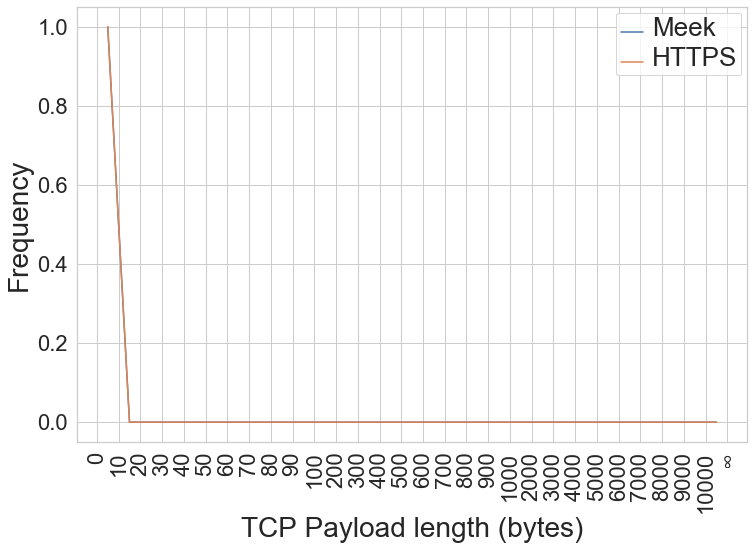

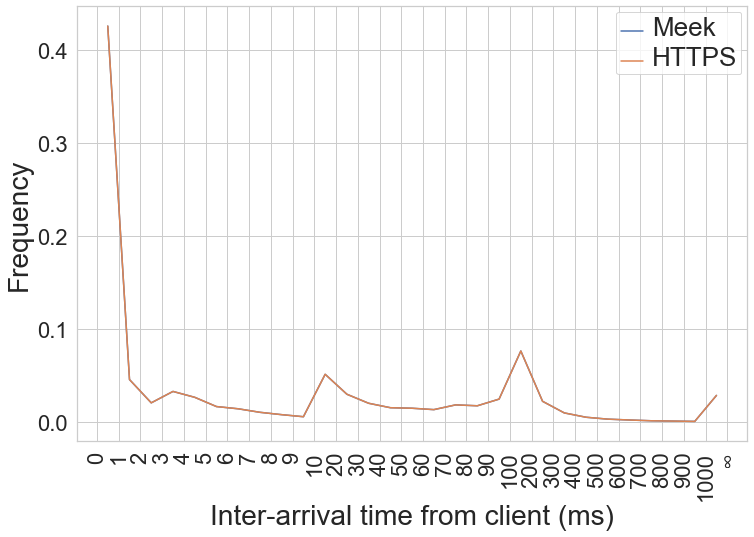

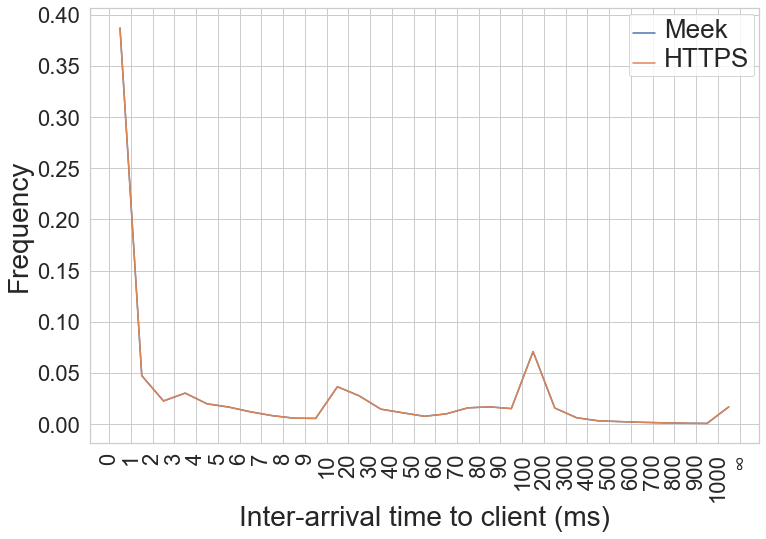

**Dataset input shape**: (90108, 3, 29)

**Dataset output shape**: (90108,)

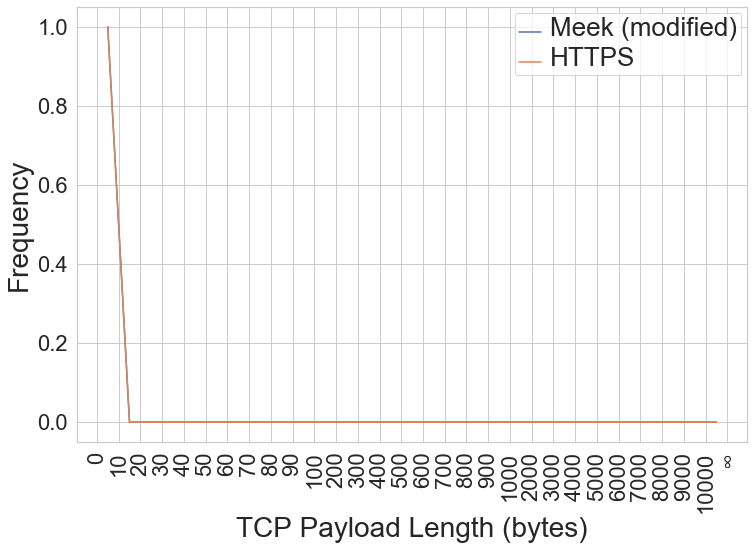

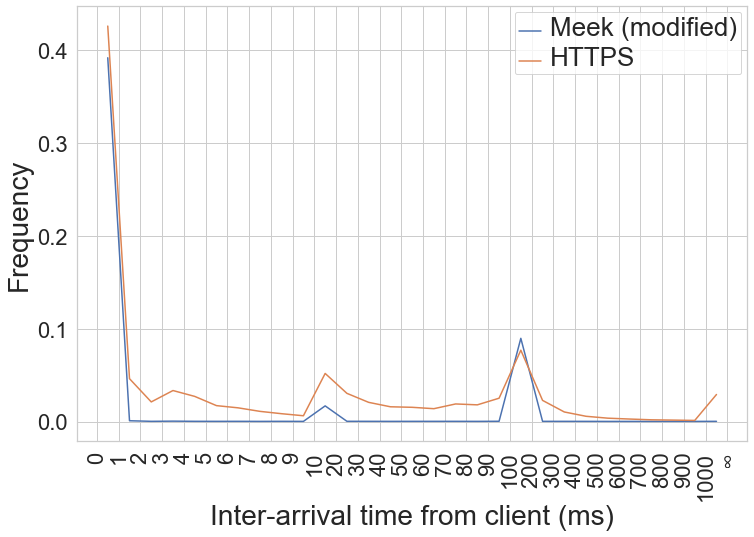

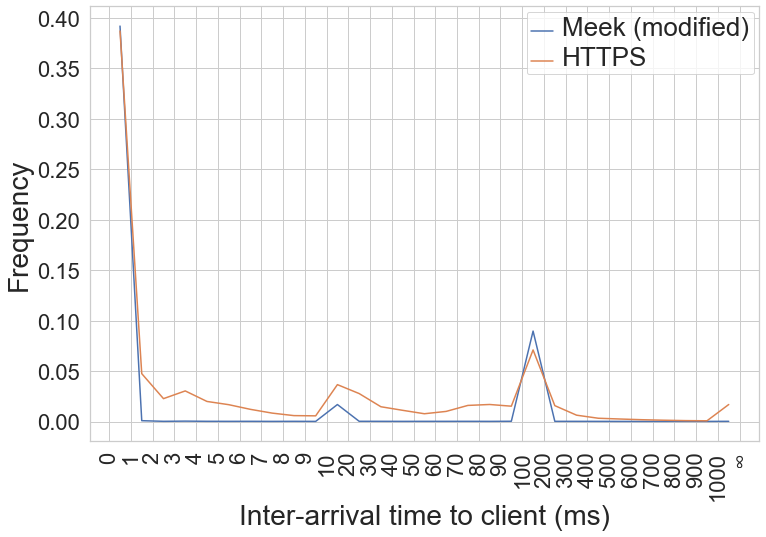

In [14]:
FIGURE_SIZE=(12,8)
normal_data, tor_data = load_data(T_ROOT)
generate_figures(normal_data, tor_data, FIGURE_DIR, FIGURE_SIZE)
generate_figures_mod(normal_data, tor_data, FIGURE_DIR, FIGURE_SIZE)

In [17]:
# Seed the RNGs to ensure consistency
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

ds_metrics = []
ds_all_metrics = []

train_start_time = time.time()
for dataset in (H_ROOT, U_ROOT, A_ROOT):
    display(Markdown(f"# Dataset {dataset}"))
    normal_data, tor_data = load_data(dataset)
    x, y = combine_datasets(normal_data, tor_data)
    avg_metrics, fold_metrics = train_and_evaluate(x, y, seed=seed)
    print_all_stats(avg_metrics)
    ds_metrics.append(avg_metrics)
    ds_all_metrics += fold_metrics
train_duration = time.time() - train_start_time
print(f"Experiments completed after {train_duration} seconds")
ds_avg_metrics = {}
for key in ds_metrics[0].keys():
    ds_avg_metrics[key] = np.mean([fold[key] for fold in ds_metrics], axis=0)
print()
display(Markdown("# Average"))
print_all_stats(ds_avg_metrics)

# Dataset /mnt/data/pcap_data/blake/output-2019-02-25-01

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/pcap_data/blake/output-2019-02-25-01/normal.json.gz'

In [18]:
#print_all_stats(ds_avg_metrics)

In [19]:
orig = []
modified = []
for ds_metric in ds_all_metrics:
    orig.append(ds_metric['discriminator/pre_transform/pr_auc'])
    modified.append(ds_metric['discriminator/post_transform/pr_auc'])
from scipy.stats import wilcoxon
wilcoxon(orig, modified)

ValueError: zero_method 'wilcox' and 'pratt' do not work if the x - y is zero for all elements.